# Reading segy headers and data using dask

---


In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import os, segyio
import pandas as pd
import re
import dask.array as da
from dask import delayed
import dask

In [2]:
# check vevn name
venv_env = os.environ.get('VIRTUAL_ENV') or sys.prefix
print(f"Using virtual environment: {os.path.basename(venv_env)}")

Using virtual environment: parallel_seismic


In [7]:
filename = "KAHU-3D-PR3177-FM.3D.Final_Migration.sgy"
def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header
# define bite positions for headers for inline and crossline    
bites = [181,185]
with segyio.open(filename,'r',ignore_geometry=True) as f:
    f.mmap()
    n_twt      = f.samples
    n_traces   = f.tracecount
    data_dtype = f.trace.raw[0].dtype
    dt = n_twt[1]-n_twt[0]
    # build a DataFrame of your custom byte‐position headers
    df = pd.DataFrame()
    for bite in bites:
        # find the matching segyio.TraceField name
        hdr_name = next(k for k,v in segyio.tracefield.keys.items() if v == bite)
        hdr_field = getattr(segyio.TraceField, hdr_name)
        df[hdr_name] = f.attributes(hdr_field)[:]
    
    print("Total traces ",n_traces)
    print("Total samples ",len(n_twt))
    print("Sampling interval ",dt)
    print("Tmin ", n_twt[0],"Tmin ", n_twt[-1])
    #headers = parse_text_header(f)

Total traces  994230
Total samples  1500
Sampling interval  4.0
Tmin  0.0 Tmin  5996.0


In [18]:
df.describe()

,CDP_X,CDP_Y
count,994230.000000,994230.000000
mean,1288.725443,2702.687125
std,169.617710,967.527012
min,996.000000,1008.000000
25%,1142.000000,1872.000000
50%,1288.000000,2702.000000
75%,1435.000000,3532.000000
max,1594.000000,4400.000000


In [4]:
#
def seismic_slice_extraction(segyfile,df,col_idx,value,ext=True):
    """
    extract a seismic slice from a segy file based on a inline or crossline value
    :param segyfile: str, path to the segy file
    :param df: pandas DataFrame, DataFrame containing inline/crossline headers
    :param col_idx: int, index of the column in df to search for the value
    :param value: int, the inline or crossline value to match
    :param ext: bool, if True, return the extent of the slice, otherwise return only the slice as a numpy array
    """
    # select the column by index
    col_series = df.iloc[:, col_idx]
    # inline/xline extent
    min_, max_ = df.iloc[:, df.columns != df.columns[col_idx]].squeeze().agg(['min','max'])

    # mask for exact match
    mask = col_series == value
    if mask.any():
        idxs = df.index[mask].tolist()
        #print(f"Row min/max indexes: ",idxs[0],idxs[-1])
    if not mask.any():
        print(f"Slice {value} not found in column #{col_idx}.")

    with segyio.open(filename,'r',ignore_geometry=True) as f:
        f.mmap()
        n_twt    = f.samples
        selected = np.vstack([f.trace.raw[i] for i in idxs])
    extent = [min_,max_,n_twt[0],n_twt[-1]]
    if ext:
        return selected,extent
    else:
        return selected

@delayed
def extract_slice_delayed(segyfile, df, col_idx, value):
    """Delayed version for dask computation"""
    result = seismic_slice_extraction(segyfile, df, col_idx, value, ext=False)
    return result

In [ ]:
# Choose which column to slice on (0 for inline, 1 for crossline)
col_idx = 0
start_value = 1300
step = 2
num_slices = 50
slice_values = [start_value + i * step for i in range(num_slices)]

# Dask: Create a list of delayed tasks, one for each slice value.
# Each delayed object represents a computation that will be executed in parallel when triggered.
delayed_slices = [extract_slice_delayed(filename, df, col_idx, value) for value in slice_values]

# Get a sample slice to determine the shape and dtype for Dask arrays.
# This is important for Dask to know how to allocate memory and chunk the data.
sample_slice = seismic_slice_extraction(filename, df, col_idx, slice_values[0], ext=True)

# Convert each delayed slice into a Dask array.
# from_delayed wraps the delayed computation as a Dask array with known shape and dtype.
slice_arrays = [da.from_delayed(delayed_slice,
                               shape=sample_slice[0].shape,
                               dtype=sample_slice[0].dtype)
                for delayed_slice in delayed_slices]

# Stack all Dask arrays along a new axis to create a 3D Dask array.
# This allows you to work with the entire volume as a single Dask array.
stacked_array = da.stack(slice_arrays, axis=0)
print(stacked_array.shape)

# Compute triggers the actual computation and loads the result into memory as a NumPy array.
# Until this point, all operations are lazy and nothing is actually loaded or processed.
output_array = stacked_array.compute()
print(output_array.shape)


(50, 1697, 1500)
(50, 1697, 1500)


In [29]:
col_idx = 0
start_value = 1000
step = 2
num_slices = 100

# Generate slice values using numpy
slice_values = np.arange(start_value, start_value + num_slices * step, step)

# Get a sample slice to determine shape and dtype
sample_slice = seismic_slice_extraction(filename, df, col_idx, slice_values[0], ext=False)
slice_shape = sample_slice.shape

# Create delayed function for single slice
@delayed
def extract_single_slice(segyfile, df, col_idx, value):
    return seismic_slice_extraction(segyfile, df, col_idx, value, ext=False)

# Create 100 delayed tasks - one for each slice value
delayed_tasks = tuple(extract_single_slice(filename, df, col_idx, val) for val in slice_values)

# Stack them into one dask array
stacked_array = da.stack([da.from_delayed(task, shape=slice_shape, dtype=sample_slice.dtype) 
                         for task in delayed_tasks])

print(stacked_array.shape)

# Compute triggers parallel execution of all 100 tasks
output_array = stacked_array.compute()
print(output_array.shape)

(100, 1697, 1500)
(100, 1697, 1500)


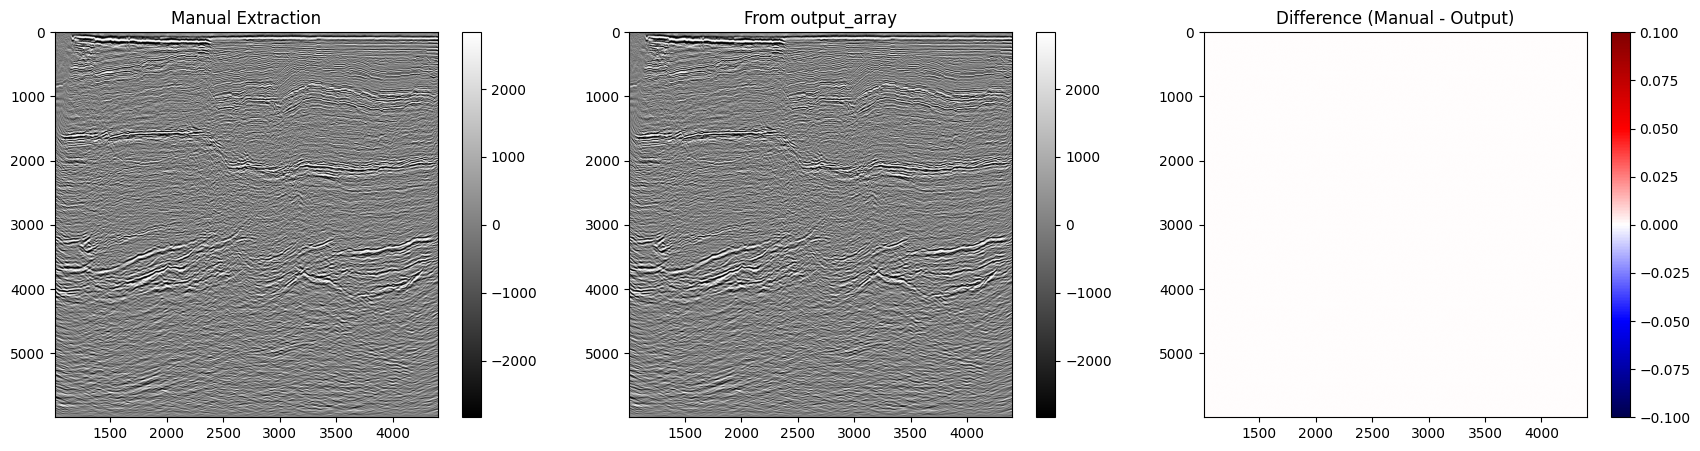

In [31]:
n = 70
data1, extent1 = seismic_slice_extraction(filename, df, 0, slice_values[n], ext=True)
data2 = output_array[n]
# Plot both slices and their difference side by side
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

v1 = np.percentile(np.abs(data1), 95)
v2 = np.percentile(np.abs(data2), 95)
# Manual Extraction
im1 = axes[0].imshow(data1.T, aspect="auto", cmap="gray", vmin=-v1, vmax=v1, extent=extent1, origin="lower")
axes[0].set_title("Manual Extraction")
axes[0].invert_yaxis()
fig.colorbar(im1, ax=axes[0])

# From output_array
im2 = axes[1].imshow(data2.T, aspect="auto", cmap="gray", vmin=-v2, vmax=v2, extent=extent1, origin="lower")
axes[1].set_title("From output_array")
axes[1].invert_yaxis()
fig.colorbar(im2, ax=axes[1])

# Difference
diff = data1 - data2
v_diff = np.percentile(np.abs(diff), 95)
im3 = axes[2].imshow(diff.T, aspect="auto", cmap="seismic", vmin=-v_diff, vmax=v_diff, extent=extent1, origin="lower")
axes[2].set_title("Difference (Manual - Output)")
axes[2].invert_yaxis()
fig.colorbar(im3, ax=axes[2])

,CDP_X,CDP_Y
count,994230.000000,994230.000000
mean,1288.725443,2702.687125
std,169.617710,967.527012
min,996.000000,1008.000000
25%,1142.000000,1872.000000
50%,1288.000000,2702.000000
75%,1435.000000,3532.000000
max,1594.000000,4400.000000
